In [1]:
# Run this cell to upload your kaggle.json file
from google.colab import files

print("Please upload your kaggle.json file")
files.upload()

# Make directory and move the file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Please upload your kaggle.json file


Saving kaggle.json to kaggle.json


In [2]:
# Install required libraries quietly
!pip install transformers datasets -q

# Download and unzip the dataset from Kaggle
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
!unzip -q imdb-dataset-of-50k-movie-reviews.zip

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
  0% 0.00/25.7M [00:00<?, ?B/s]
100% 25.7M/25.7M [00:00<00:00, 303MB/s]


In [3]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import nltk

# Suppress warnings for a cleaner output
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings('ignore')

# --- NLP LIBRARIES ---
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_curve, roc_auc_score, accuracy_score,
                             precision_score, recall_score, f1_score)
from datasets import Dataset
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

print("--- Project Aether: Complete Colab Run ---")

--- Project Aether: Complete Colab Run ---


In [4]:
# --- PART 1: LOAD AND PREPROCESS DATA ---
print("\n--- Part 1: Loading and preparing data... ---")
# Download NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
df = pd.read_csv('IMDB Dataset.csv')
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    tokens = text.lower().split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['cleaned_review'] = df['review'].apply(preprocess_text)

# Create a single, consistent train/test split for both models
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_review'], df['sentiment'], test_size=0.2, random_state=42, stratify=df['sentiment']
)
print("Data preprocessing complete.")


--- Part 1: Loading and preparing data... ---
Data preprocessing complete.


In [5]:
# --- PART 2: TRAIN BASELINE & GET PREDICTIONS ---
print("\n--- Part 2: Training baseline Logistic Regression model... ---")
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)
y_pred_lr = lr_model.predict(X_test_tfidf)
y_pred_prob_lr = lr_model.predict_proba(X_test_tfidf)[:, 1]
print("Baseline model trained.")


--- Part 2: Training baseline Logistic Regression model... ---
Baseline model trained.


In [6]:
# --- PART 3: TRAIN TRANSFORMER MODEL ---
print("\n--- Part 3: Fine-tuning Transformer model... (This will take a few minutes on the GPU) ---")
train_dataset = Dataset.from_dict({'text': X_train.tolist(), 'label': y_train.tolist()})
test_dataset = Dataset.from_dict({'text': X_test.tolist(), 'label': y_test.tolist()})

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length")

tokenized_train = train_dataset.map(tokenize_function, batched=True).rename_column("label", "labels")
tokenized_test = test_dataset.map(tokenize_function, batched=True).rename_column("label", "labels")

tf_train_set = tokenized_train.to_tf_dataset(columns=["attention_mask", "input_ids"], label_cols="labels", shuffle=True, batch_size=16)
tf_test_set = tokenized_test.to_tf_dataset(columns=["attention_mask", "input_ids"], label_cols="labels", shuffle=False, batch_size=16)

transformer_model = TFAutoModelForSequenceClassification.from_pretrained("distilbert/distilbert-base-uncased", num_labels=2, from_pt=True)
transformer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=["accuracy"])
transformer_model.fit(tf_train_set, validation_data=tf_test_set, epochs=2)
print("Transformer model trained.")


--- Part 3: Fine-tuning Transformer model... (This will take a few minutes on the GPU) ---


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSeq

Epoch 1/2
2500/2500 [==============================] - 2415s 955ms/step - loss: 0.2909 - accuracy: 0.8780 - val_loss: 0.2401 - val_accuracy: 0.9022
Epoch 2/2
2500/2500 [==============================] - 2388s 955ms/step - loss: 0.1677 - accuracy: 0.9371 - val_loss: 0.2379 - val_accuracy: 0.9009
Transformer model trained.


In [7]:
# --- PART 4: TEST THE TRANSFORMER ON CUSTOM SENTENCES ---
print("\n--- Part 4: Testing Transformer on new sentences... ---")
def predict_sentiment_transformer(text_input, model, tokenizer):
    inputs = tokenizer(text_input, return_tensors="tf", truncation=True, padding=True)
    logits = model(inputs).logits
    probabilities = tf.nn.softmax(logits, axis=-1).numpy()
    prediction = np.argmax(probabilities, axis=1)[0]
    confidence = probabilities[0][prediction]
    sentiment = "Positive" if prediction == 1 else "Negative"
    return f"Sentiment: {sentiment} (Confidence: {confidence:.2f})"

test_sentences = [
    "I loved this movie! The performances were brilliant and the story was unforgettable.",
    "A complete waste of my time. The plot was boring and made no sense.",
    "I didn't hate the movie, and some parts were not bad at all.",
    "An absolute masterpiece of filmmaking. I've only seen this exact same story a dozen times before."
]
for sentence in test_sentences:
    print(f"Review: '{sentence}'")
    print(predict_sentiment_transformer(sentence, transformer_model, tokenizer))
    print("-" * 30)

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.



--- Part 4: Testing Transformer on new sentences... ---
Review: 'I loved this movie! The performances were brilliant and the story was unforgettable.'
Sentiment: Positive (Confidence: 0.99)
------------------------------
Review: 'A complete waste of my time. The plot was boring and made no sense.'
Sentiment: Negative (Confidence: 1.00)
------------------------------
Review: 'I didn't hate the movie, and some parts were not bad at all.'
Sentiment: Negative (Confidence: 0.54)
------------------------------
Review: 'An absolute masterpiece of filmmaking. I've only seen this exact same story a dozen times before.'
Sentiment: Positive (Confidence: 0.99)
------------------------------


In [8]:
# --- PART 5: GENERATE PREDICTIONS FOR GRAPHS ---
print("\n--- Part 5: Generating predictions for graphs... ---")
predictions = transformer_model.predict(tf_test_set)
logits = predictions['logits']
probabilities_transformer = tf.nn.softmax(logits, axis=1).numpy()
y_pred_prob_transformer = probabilities_transformer[:, 1]
y_pred_transformer = np.argmax(probabilities_transformer, axis=1)


--- Part 5: Generating predictions for graphs... ---
625/625 [==============================] - 195s 310ms/step



--- Part 6: Generating final performance graphs... ---

--- Classification Report: Logistic Regression ---
              precision    recall  f1-score   support

    Negative       0.90      0.88      0.89      5000
    Positive       0.88      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000


--- Classification Report: Transformer (DistilBERT) ---
              precision    recall  f1-score   support

    Negative       0.94      0.86      0.90      5000
    Positive       0.87      0.94      0.91      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



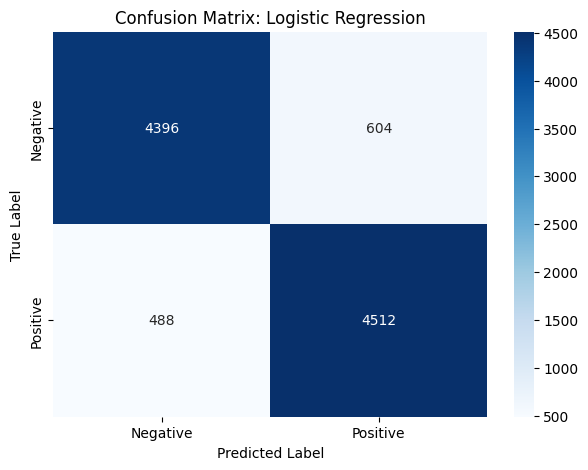

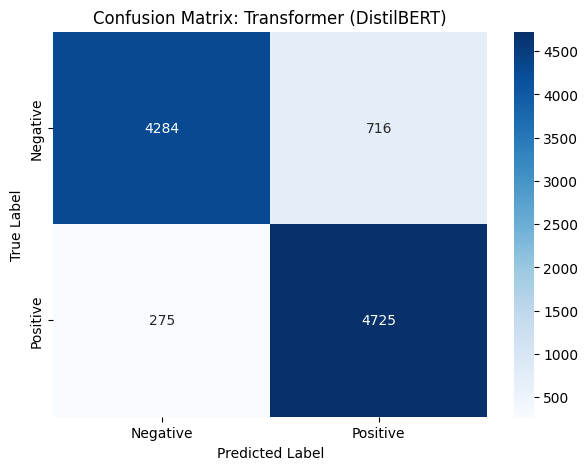

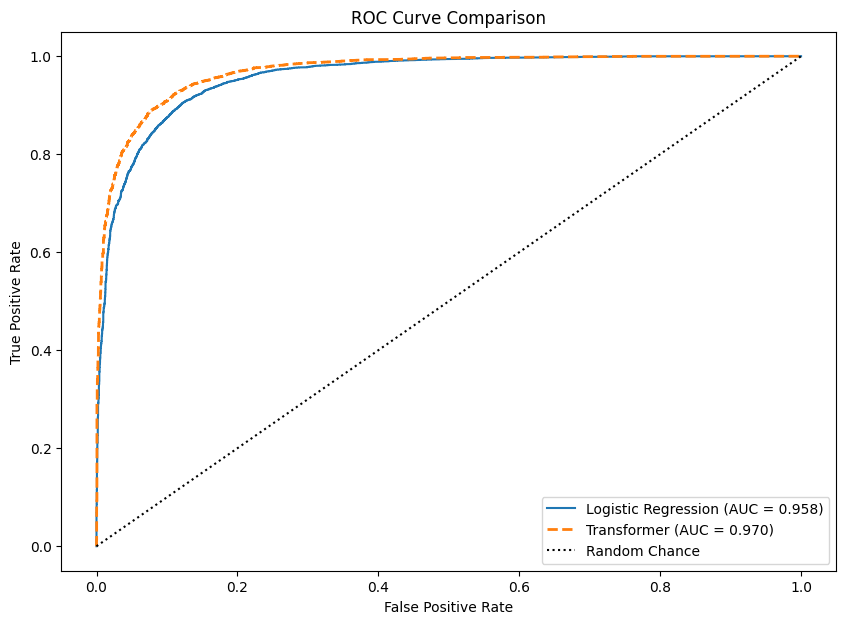

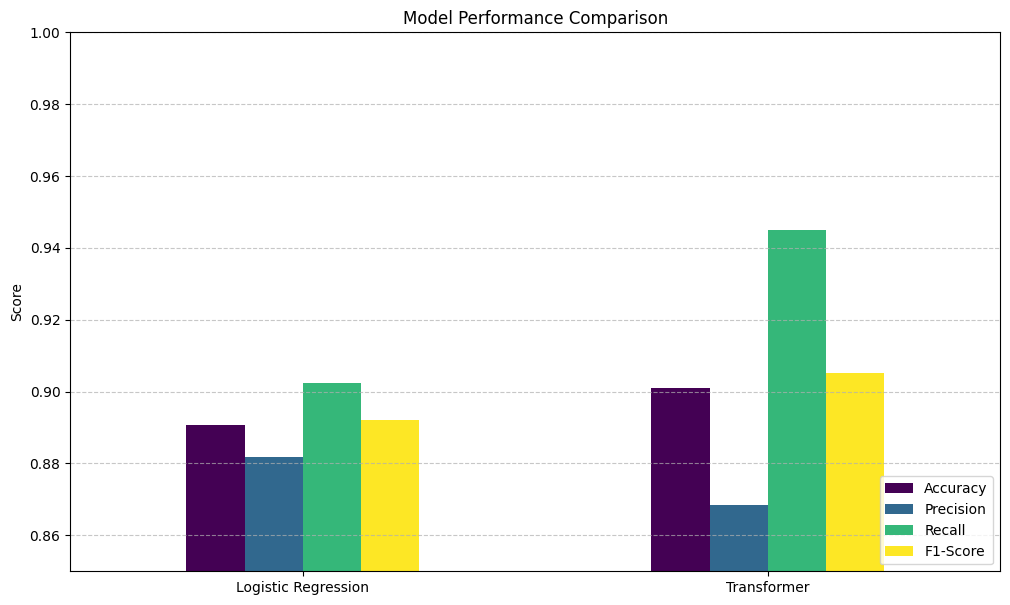


--- All steps are complete. Project Aether is finished. ---


In [9]:
# --- PART 6: PLOT ALL COMPARISON GRAPHS ---
print("\n--- Part 6: Generating final performance graphs... ---")
# Classification Reports
print("\n--- Classification Report: Logistic Regression ---")
print(classification_report(y_test, y_pred_lr, target_names=['Negative', 'Positive']))
print("\n--- Classification Report: Transformer (DistilBERT) ---")
print(classification_report(y_test, y_pred_transformer, target_names=['Negative', 'Positive']))

# Confusion Matrices
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.show()

plot_confusion_matrix(y_test, y_pred_lr, "Logistic Regression")
plot_confusion_matrix(y_test, y_pred_transformer, "Transformer (DistilBERT)")

# ROC Curve Comparison
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_prob_lr)
auc_lr = roc_auc_score(y_test, y_pred_prob_lr)
fpr_transformer, tpr_transformer, _ = roc_curve(y_test, y_pred_prob_transformer)
auc_transformer = roc_auc_score(y_test, y_pred_prob_transformer)

plt.figure(figsize=(10, 7))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.3f})')
plt.plot(fpr_transformer, tpr_transformer, label=f'Transformer (AUC = {auc_transformer:.3f})', linewidth=2, linestyle='--')
plt.plot([0, 1], [0, 1], 'k:', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

# Bar Chart of Key Metrics
metrics_data = {
    'Logistic Regression': {
        'Accuracy': accuracy_score(y_test, y_pred_lr),
        'Precision': precision_score(y_test, y_pred_lr),
        'Recall': recall_score(y_test, y_pred_lr),
        'F1-Score': f1_score(y_test, y_pred_lr)
    },
    'Transformer': {
        'Accuracy': accuracy_score(y_test, y_pred_transformer),
        'Precision': precision_score(y_test, y_pred_transformer),
        'Recall': recall_score(y_test, y_pred_transformer),
        'F1-Score': f1_score(y_test, y_pred_transformer)
    }
}
df_metrics = pd.DataFrame(metrics_data).T

df_metrics.plot(kind='bar', figsize=(12, 7), colormap='viridis')
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0.85, 1.0)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("\n--- All steps are complete. Project Aether is finished. ---")